    Lucas Tsunaki
    27.06.2024

On this example I define the simplest 1/2 system 

**Table of contents**<a id='toc0_'></a>    
- 1. [Defining the Spin 1/2 System](#toc1_)    
- 2. [Rabi Oscillation](#toc2_)    
- 3. [Hahn Echo](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, fock_dm

# 1. <a id='toc1_'></a>[Defining the Spin 1/2 System](#toc0_)

We begin defining a general two-level system with a time independet Hamiltonian given by
$$ H_0 = \frac{\Delta}{2} \sigma_z ,$$ 
where $\Delta$ is the energy difference between the two levels and $\sigma_z$ the Pauli matrix. Although simple, this Hamiltonian can represent a varied number of systems: from spin-1/2 nuclear spins in NMR, to electronic spins in EPR, to superconducting qubits. Let us assume now that the state is initialized in the state $|0 \rangle$, thus the initial density matrix is
$$ \rho_0 = |0 \rangle \langle 0 | = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix} .$$
Last, we also consider that the system has an observable given by the operator $S_z$.

In [3]:
# import the QSys class from quaccatoo
from quaccatoo.QSys import QSys

# here we define delta = 10
delta = 1

# create the QSys object with the desired parameters
qsys = QSys(
    H0 = delta/2 * sigmaz(),
    rho0 = fock_dm(2, 0),
    observable = fock_dm(2, 0)
)

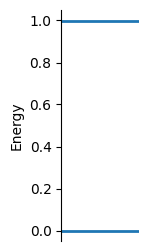

In [4]:
qsys.plot_energy(figsize=(1,3))

# 2. <a id='toc2_'></a>[Rabi Oscillation](#toc0_)

With the quantum system defined, the first measurement to perform is a Rabi oscillation. This is done by applying a resonant pulse to the system with varying length, such that it will drive the system between the two levels causing a period oscillation of the observable expectation value. Let us consider a square cosine pulse of frequency $\Delta$ applied on the x-axis of the laboratory frame. The interaction of the pulse with the system is then described in terms of a control Hamiltonian given by
$$ H_1 = \omega_1 \sigma_x ,$$
which is then multiplied by the time-dependent pulse function. $\omega_1$ is the Rabi frequency, related to the amplitude of the pulse.

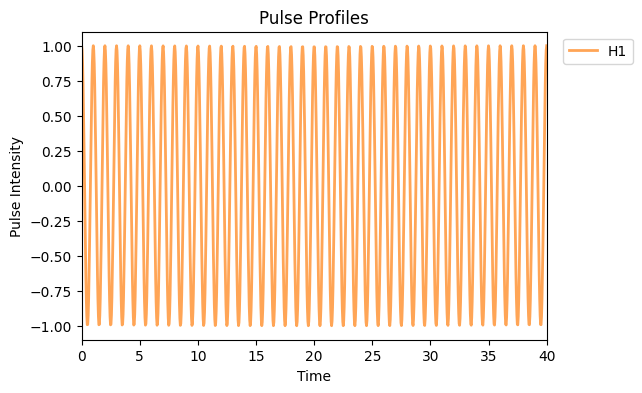

In [5]:
# import the Rabi class from the basic predefined pulsed experiments
from quaccatoo.BasicPulsedExp import Rabi
# import the square_pulse function from the predefined pulse shapes
from quaccatoo.PulseShapes import square_pulse

# let's consider a rabi frequency much smaller than the resonance frequency such that the rotating wave approximation is valid
w1 = .1

# create the Rabi object for the qsys and the desired parameters
rabi_exp = Rabi(
    pulse_duration = np.linspace(0, 40, 1000), # time array of pulse duration which we want to simulate the experiment
    system = qsys, # we pass the qsys object defined in the previous section
    H1 = w1*sigmax(), # the Hamiltonian for the interaction with the pulse
    pulse_shape = square_pulse, # the pulse shape function we want to use (this line is redundant since square_pulse is the default pulse shape function if not specified)
    pulse_params = {'omega_pulse': delta}, # we need to pass the the frequency of the pulse as the resonant frequency of the system
)

# to visualize the pulse sequence we can use the plot_pulses method, where we can see the pulse shape and the pulse duration
rabi_exp.plot_pulses()

With the run method the experiment is simulated and the expectation value of the observable is plotted with plot_results.

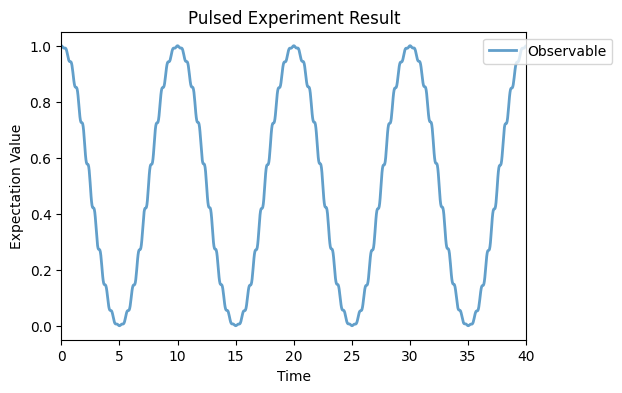

In [6]:
rabi_exp.run()
rabi_exp.plot_results()

As expected, the expectation value of the operator shows a period oscillation, but with a small modulation related to the rotating wave approximation as we chose $\Delta/\omega_1=10$. For larger rations this modulation disapear (check yourself!). Now to fit the data we use the Analysis class.

array([ 4.99055155e-01,  5.00156844e+00,  4.99687312e-01, -6.35263088e-07])

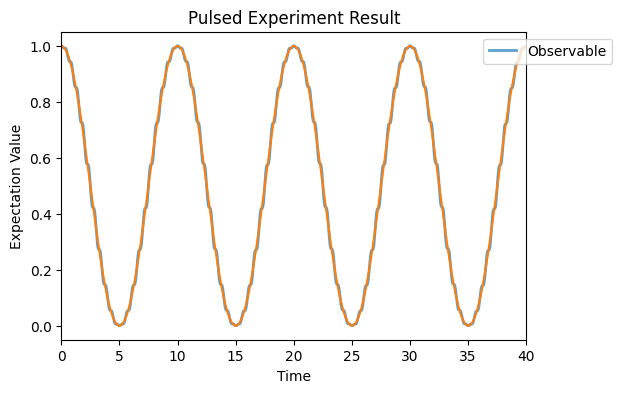

In [7]:
# import the Analysis class and the fit_rabi function
from quaccatoo.Analysis import Analysis, fit_rabi

# create the Analysis object for the Rabi experiment
rabi_analysis = Analysis(rabi_exp)

# fit the Rabi oscillations with the run_fit method
rabi_analysis.run_fit(
    fit_function = fit_rabi, # here we use the predefined fit_rabi function
    guess = [.5, 1/2/w1, .5, 0], # we can provide an initial guess for the fit parameters, check the Analysis module for the order of the parameters
    )
# plot the results of the fit
rabi_analysis.plot_fit()

# check the fit results
rabi_analysis.fit

Here we observe that the fitted value of the $\pi$-pulse duration $t_\pi \cong 5.001$ is slightly larger than the expected value of $1/(2 \omega_1) = 5$. To obtain a more accurate value, we can consider a rotating pulse with two control Hamiltonians $\omega_x$ and $\omega_y$, for that we define custom pulse shape for X and Y with a dephase of $\pi/2$ as follows.

array([ 4.99990907e-01,  4.99999924e+00,  4.99995875e-01, -1.58084758e-05])

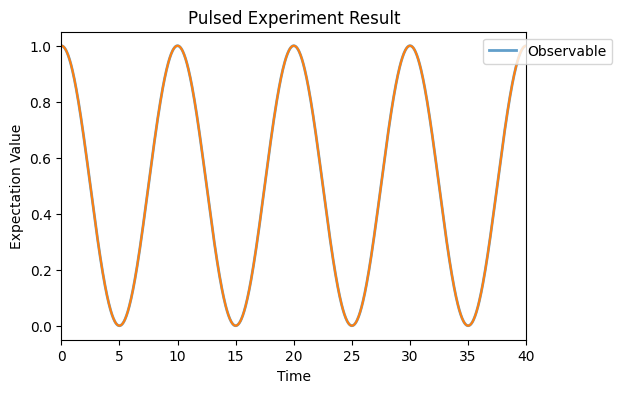

In [8]:
# define a custom pulse shape for X
def custom_pulseX(t):
    return np.cos(delta*t)

# define a custom pulse shape for Y
def custom_pulseY(t):
    return np.cos(delta*t - np.pi/2)

# create the new Rabi object for the qsys and the desired parameters
rabi_exp_2 = Rabi(
    pulse_duration = np.linspace(0, 40, 1000), # time array of pulse duration which we want to simulate the experiment
    system = qsys, # we pass the qsys object defined in the previous section
    H1 = [w1*sigmax()/2, w1*sigmay()/2], # the Hamiltonian for the interaction with the pulse now is a list with the two control Hamiltonians for X and Y
    pulse_shape = [custom_pulseX, custom_pulseY] # for the pulse_shape we pass a list with the two custom pulse shape functions, as now the custom pulses have no other parameters and pulse_params dictionary is empty
)

# run the experiment
rabi_exp_2.run()
# call Analysis class
rabi_analysis_2 = Analysis(rabi_exp_2)

# fit the Rabi oscillations with the run_fit method same as before
rabi_analysis_2.run_fit(
    fit_function = fit_rabi,
    guess = [.5, 1/2/w1, .5, 0]
    )

# plot the results of the fit
rabi_analysis_2.plot_fit()

# check the fit results
rabi_analysis_2.fit

In the rotating frame of reference, this new rotating pulse is fully aligned within the $x$-axis. Thus the modulations have disappeared and the $t_\pi$ value is closer to the expected value of $1/(2\omega_1)$.

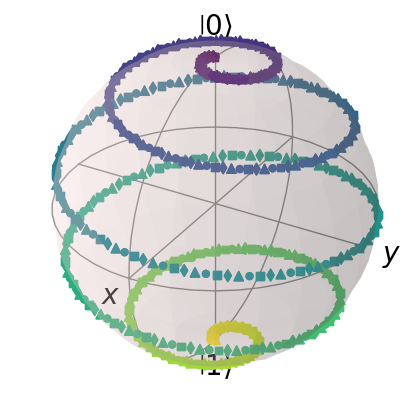

In [10]:
rabi_exp_3 = Rabi(
    pulse_duration = np.linspace(0, 1/2/w1, 500), # time array of pulse duration which we want to simulate the experiment
    system = qsys, # we pass the qsys object defined in the previous section
    H1 = [w1*sigmax()/2, w1*sigmay()/2], # the Hamiltonian for the interaction with the pulse now is a list with the two control Hamiltonians for X and Y
    pulse_shape = [custom_pulseX, custom_pulseY] # for the pulse_shape we pass a list with the two custom pulse shape functions, as now the custom pulses have no other parameters and pulse_params dictionary is empty
)

# run the experiment
rabi_exp_3.run()
# call Analysis class
rabi_analysis_3 = Analysis(rabi_exp_3)
rabi_analysis_3.plot_bloch()

# 3. <a id='toc3_'></a>[Hahn Echo](#toc0_)

Another central quantity in quantum systems is the coherence time $T_2$, being a measure of how fast a system loses its quantum information, or in other words, how fast it becomes classical. To model the non-unitary process which cause quantum decoherence we make use of the Lindblad master equation from Qutip, by defining a collapse operator
$$ C = \gamma \sigma_z ,$$
Where $\gamma$ is rate of decoherence, inversely proportional to $T_2$. The Hahn echo sequence is then used to measure the coherece time, being composed of two free evolutions with a refocusing $\pi$-pulse in between. An initial and final $\pi/2$-pulse are also included in order to project the spin the quantization axis.

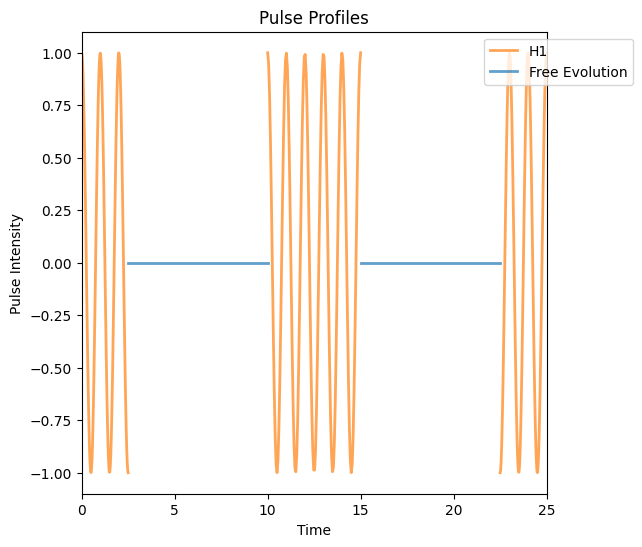

In [12]:
# define an arbitrary gamma
gamma = 0.1

# overwrite the c_ops attribute of the QSys object
qsys.c_ops = gamma * sigmaz()

# import the Hahn echo experiment from basic predefined methods
from quaccatoo.BasicPulsedExp import Hahn

hahn_exp = Hahn(
    free_duration = np.linspace(3, 25, 30), # define the array of free durations simulate
    pi_pulse_duration= 1/2/w1, # define the pi pulse duration
    # same parameters as before
    system = qsys,
    H1 = w1*sigmax(), 
    pulse_shape=square_pulse,
    pulse_params = {'omega_pulse': delta}
)

# plot the pulse sequence
hahn_exp.plot_pulses(tau=10)

In this case, we can observe the initial and final $\pi/2$ pulses, the two free evolutions and the middle $\pi$-pulse. Finnaly, running the experiment leads to an exponential decay of the observable expectation value, known as the Hahn echo decay.

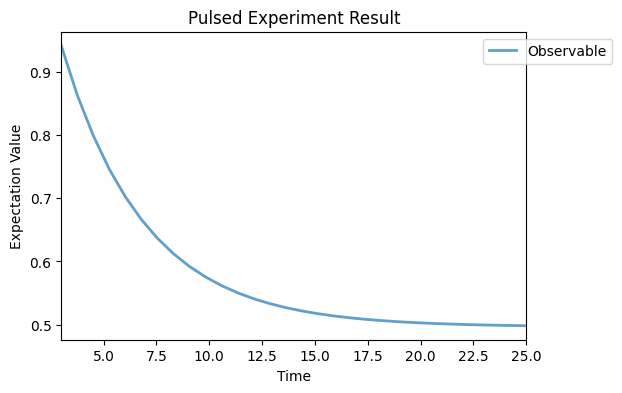

In [13]:
# run the experiment and plot the result
hahn_exp.run()
hahn_exp.plot_results()